In [2]:
%load_ext autoreload
%autoreload 2
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = f"-1"
from mgpvae.kernels import SpatiotemporalMatern32
from mgpvae.model import STMarkovGaussianProcessVAEExternal
from mgpvae.likelihood import DecoderGaussian
from mgpvae.networks import Linear
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import jax 
from jax import random
import random as random_lib
import objax
from tqdm.notebook import trange
import numpy as np
from jax.example_libraries.optimizers import clip_grads
from jax.config import config
config.update("jax_enable_x64", True)
import pandas as pd
from matplotlib import style
style.use('seaborn-poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_2304654/2842381954.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-poster')


```python
features = [
    "longitude",	
    "latitude",	
    "mean_2m_air_temperature",	
    "minimum_2m_air_temperature",	
    "maximum_2m_air_temperature",	
    "dewpoint_2m_temperature",	
    "total_precipitation",	
    "surface_pressure",	
    "mean_sea_level_pressure",	
    "u_component_of_wind_10m",	
    "v_component_of_wind_10m",
]
```

In [3]:
num_latent = 8
num_hidden = 16
num_channels = 1
minibatch_size = 1
num_epochs = 1
lr_adam = 1e-3
num_space = 60
seed = 0
## set random seed 
random_lib.seed(seed)

In [6]:
region = "guangdong"
sequence_original = np.load(f"data/era5/original_{region}.npz")["sequence"]
sequence_original = sequence_original[:, :100, :]
lon_min, lon_max = 112, 114
lat_min, lat_max = 20, 24
sequence_original = sequence_original[
    (sequence_original[:,0,0] < lon_max) & (sequence_original[:,0,0] > lon_min), 
    :, 
    :
]
sequence_original = sequence_original[
    (sequence_original[:,0,1] < lat_max) & (sequence_original[:,0,1] > lat_min), 
    :, 
    :
]

# create train set
spatial_loc_index = random_lib.choices(np.arange(sequence_original.shape[0]), k=num_space)
sequence = sequence_original[spatial_loc_index]
T = np.arange(0, sequence.shape[1])[:, None]
out_columns = [2, 3, 4, 5, 7, 8, 9, 10]
y_dim = len(out_columns)
R = sequence[:,0,:2]

df_elevation = pd.read_csv("data/era5/elevation_guangdong.csv")
df_R = pd.DataFrame(R, columns=["longitude", "latitude"])
df_R["index"] = spatial_loc_index
df_space = df_R.merge(df_elevation)[["longitude", "latitude", "elevation", "index"]]
R_train = df_space[["longitude", "latitude", "elevation"]].values
scaler_x = StandardScaler().fit(R_train)
R_train_transformed = scaler_x.transform(R_train)
Y_train = sequence_original[df_space["index"]][:, :, out_columns]

num_space = R_train_transformed.shape[0]
num_time = sequence.shape[1]
scaler_y = StandardScaler().fit(Y_train.reshape(-1, y_dim))
Y_train_transformed = scaler_y.transform(Y_train.reshape(-1, y_dim)).reshape(num_space, -1, y_dim)

## create test set
spatial_loc_test_index = list(set([i for i in range(sequence_original.shape[0])]) - set(spatial_loc_index))
R_test = sequence_original[spatial_loc_test_index,0,:2]
df_elevation = pd.read_csv("data/era5/elevation_guangdong.csv")
df_R = pd.DataFrame(R_test, columns=["longitude", "latitude"])
df_R["index"] = spatial_loc_test_index
df_space = df_R.merge(df_elevation)[["longitude", "latitude", "elevation", "index"]]
R_test = df_space[["longitude", "latitude", "elevation"]].values
R_test_transformed = scaler_x.transform(R_test)
Y_test = sequence_original[df_space["index"]][:, :, out_columns]
Y_test_transformed = scaler_y.transform(Y_test.reshape(-1, y_dim)).reshape(Y_test.shape[0], -1, y_dim)

In [7]:
print(f"Train: Y: {Y_train_transformed.shape}, R: {R_train_transformed.shape}, T: {T.shape}")
print(f"Test: Y: {Y_test_transformed.shape}, R: {R_test_transformed.shape}, T: {T.shape}")
print(f"#spatial locations: {num_space}, #temporal points {num_time}, data dimension {y_dim}")

Train: Y: (59, 100, 8), R: (59, 3), T: (100, 1)
Test: Y: (34, 100, 8), R: (34, 3), T: (100, 1)
#spatial locations: 59, #temporal points 100, data dimension 8


In [9]:
## Model Definition

# first define the kernel
k_t = SpatiotemporalMatern32(
    R=R_train_transformed,
    lengthscale=2, 
    variance=1,
    lengthscale_time=jax.numpy.ones(num_latent)*5, # each dimension has its own kernel hyperparameters
    variance_time=jax.numpy.ones(num_latent), # each dimension has its own kernel hyperparameters
    fix_variance=True
)
# not really used so ignore
dt = np.array([0] + list(np.diff(T, axis=0)[:, 0]))


# define neural networks
def decoder_blocks(nin, nout):
    return objax.nn.Sequential([
        Linear(nin, 16), 
        objax.functional.relu,
        Linear(16, nout), 
    ])

# encoder only includes first layer because we pass it to hidden_to_mu networks
def simple_net_block(nin, n_hidden):
    return objax.nn.Sequential([
        Linear(nin, n_hidden), 
        objax.functional.relu,
    ])


# Decoder
decoder = decoder_blocks(num_latent, y_dim)
decoder_likelihood = DecoderGaussian(decoder, variance=1, num_latent=num_latent, y_dim=y_dim)

# Encoder
encoder = simple_net_block(y_dim, num_hidden)
hidden_to_mu = objax.nn.Sequential(
    [
        Linear(num_hidden, num_latent),
    ]
)
hidden_to_var = objax.nn.Sequential(
    [
        Linear(num_hidden, num_latent),
    ]
)

##
model = STMarkovGaussianProcessVAEExternal(
    kernel = k_t,
    likelihood = decoder_likelihood,
    encoder = encoder,
    num_hidden=num_hidden,
    hidden_to_mu=hidden_to_mu,
    hidden_to_var=hidden_to_var,
    num_latent=num_latent,
    dt=None, # not really needed
    minibatch_size=num_time, # not really used
    num_sequences=1, # not really needed
    parallel=False,
)

In [10]:
mode = "kriging"
ckpt_debug = objax.io.Checkpoint(logdir=f"model_checkpoints/era5/markovgpvae_region{region}_{seed}_mode{mode}_{num_latent}", keep_ckpts=20000)
ckpt_debug.restore(model.vars(), 19999)

Resuming from model_checkpoints/era5/markovgpvae_regionguangdong_0_modekriging_8/ckpt/0000019999.npz


(19999,
 'model_checkpoints/era5/markovgpvae_regionguangdong_0_modekriging_8/ckpt/0000019999.npz')

In [11]:
nll, expected_density,mean_f, var_f = model.compute_nll(T, Y_train_transformed, T, Y_test_transformed, R_test_transformed, 0, 20)
print(nll)

0.353564415902406


In [13]:
posterior_mean, posterior_var,mean_f,var_f = model.predict_y(T, T, Y_train_transformed, R_test=R_test_transformed, num_samples=100)
posterior_mean_inverse_transformed = scaler_y.inverse_transform(posterior_mean.reshape(-1, y_dim)).reshape(posterior_mean.shape)
rmse = np.mean(np.sqrt(np.sum((posterior_mean_inverse_transformed-Y_test)**2, axis=-1)))
print(rmse)

281.4182846748869


In [14]:
## temporal plots
## spatial predictions
# at new locations
# now we plot them in the inverse_transformed/original space

posterior_mean, posterior_var,mean_f,var_f = model.predict_y(T, T, Y_train_transformed, R_test=R_test_transformed, num_samples=5)
plot_dim = 0
y_mean = scaler_y.inverse_transform(posterior_mean[:,0,:])
posterior_mean_inverse_transformed = scaler_y.inverse_transform(posterior_mean.reshape(-1, y_dim)).reshape(posterior_mean.shape)
lower = posterior_mean - 1.96*np.sqrt(posterior_var)
upper = posterior_mean + 1.96*np.sqrt(posterior_var)
lower_inverse_transformed = scaler_y.inverse_transform(lower.reshape(-1, y_dim)).reshape(posterior_mean.shape)
upper_inverse_transformed = scaler_y.inverse_transform(upper.reshape(-1, y_dim)).reshape(posterior_mean.shape)



(array([270., 275., 280., 285., 290., 295., 300., 305., 310.]),
 [Text(0, 270.0, '270'),
  Text(0, 275.0, '275'),
  Text(0, 280.0, '280'),
  Text(0, 285.0, '285'),
  Text(0, 290.0, '290'),
  Text(0, 295.0, '295'),
  Text(0, 300.0, '300'),
  Text(0, 305.0, '305'),
  Text(0, 310.0, '310')])

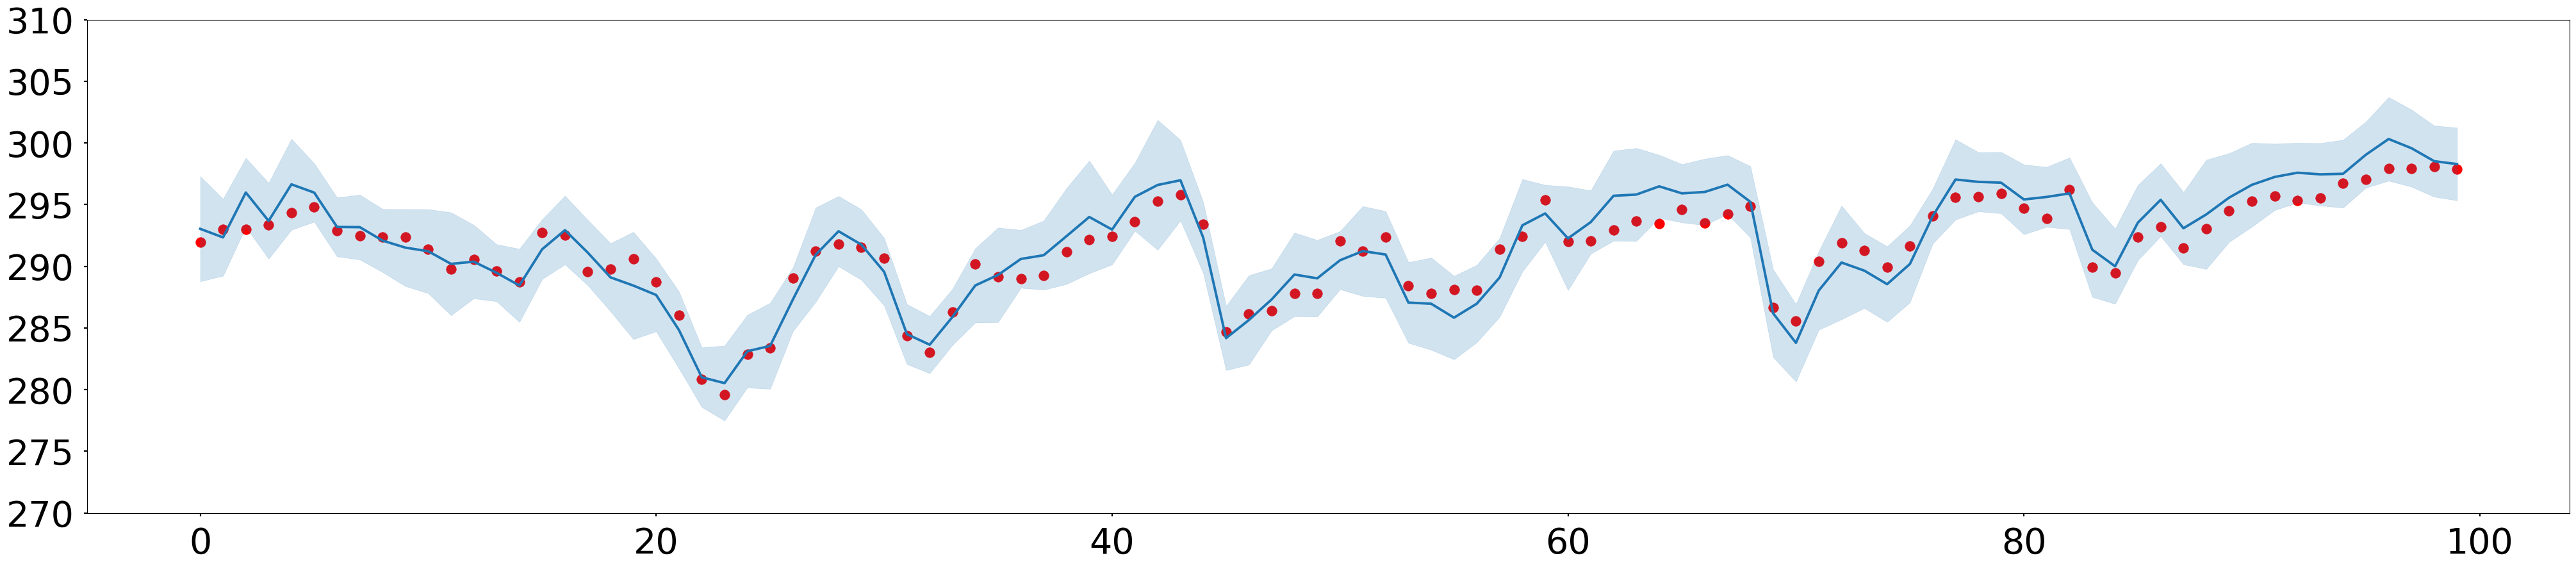

In [16]:
# plotting in the original space
plot_dim=2
plot_spatial_loc = 5
plt.figure(figsize=(50,10))
plt.plot(T, posterior_mean_inverse_transformed[plot_spatial_loc,:,plot_dim])
plt.scatter(T, Y_test[plot_spatial_loc,:,plot_dim], color="red")
plt.fill_between(
    T[:,0],
    lower_inverse_transformed[plot_spatial_loc,:, plot_dim],
    upper_inverse_transformed[plot_spatial_loc,:, plot_dim],
    color="C0", 
    alpha=0.2,
)
plt.ylim(270, 310)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

## Training

In [17]:
mode = "missing"
opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())

@objax.Function.with_vars(opt_hypers.vars() + model.vars())
def train_op(epoch):
    dE, (E, negative_varexp, kl) = energy(Y_train_transformed, random.PRNGKey(epoch), t=T, num_samples=1)  # compute energy and its gradients w.r.t. hypers
    opt_hypers(lr_adam, dE)
    dE = clip_grads(dE, 100)
    return E, negative_varexp, kl, dE
train_op = objax.Jit(train_op)

In [18]:
# Do some training
mode = "missing"
opt_hypers = objax.optimizer.Adam(model.vars())
energy = objax.GradValues(model.energy, model.vars())

@objax.Function.with_vars(opt_hypers.vars() + model.vars())
def train_op(epoch):
    dE, (E, negative_varexp, kl) = energy(Y_train_transformed, random.PRNGKey(epoch), t=T, num_samples=1)  # compute energy and its gradients w.r.t. hypers
    opt_hypers(lr_adam, dE)
    dE = clip_grads(dE, 100)
    return E, negative_varexp, kl
train_op = objax.Jit(train_op)

num_epochs = 10
iterator = trange(num_epochs) 
ckpt = objax.io.Checkpoint(logdir=f"results/markovgpvae_region{region}_{seed}_mode{mode}_{num_latent}", keep_ckpts=num_epochs)

for i in iterator:
    E, negative_varexp, kl = train_op(epoch=i)
    iterator.set_description(f"iter {i}: -ELBO: {E}")
    if i % 100 == 0:
        ckpt.save(model.vars(), idx=i)
        # all visualisations here are on the transformed space
        # temporal prediction
        posterior_mean, posterior_var,mean_f,var_f = model.predict_y(T, T, Y_train_transformed, R_test=R_test_transformed, num_samples=5)
        ## take first spatial location to plot
        plot_dim = 3
        fig = plt.figure(figsize=(50,10))
        plt.plot(T[:, 0], posterior_mean[0,:,0])
        plt.scatter(T, Y_train_transformed[0,:,0], color="red")
        plt.fill_between(
            T[:, 0],
            (posterior_mean - 1.96 * np.sqrt(posterior_var))[0,:, 0],
            (posterior_mean + 1.96 * np.sqrt(posterior_var))[0,:, 0],
            color="C0", 
            alpha=0.2,
        )
        plt.colorbar()
        plt.savefig(f"./test_temporal_predictions_{i}.png")
        plt.close()

        # plot the predictions at out of sample spatial locations
        plot_dim = 3
        y_mean = posterior_mean[:,0,:]
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.scatter(R_test_transformed[:,0], R_test_transformed[:,1], c=Y_test_transformed[:,0,plot_dim:plot_dim+1], marker=",")
        ax1.scatter(R_train_transformed[:,0], R_train_transformed[:,1], marker=",", edgecolor="black", linewidth=2, facecolors="None")
        ax1.set_title("Original")
        im = ax2.scatter(R_test_transformed[:,0], R_test_transformed[:,1], c=y_mean[:, plot_dim], marker=",")
        ax2.scatter(R_train_transformed[:,0], R_train_transformed[:,1], marker=",", edgecolor="black", linewidth=2, facecolors="None")
        ax2.set_title("Posterior Mean")
        plt.savefig(f"./test_spatial_predictions_{i}.png")
        plt.close()

  0%|          | 0/10 [00:00<?, ?it/s]